## PyTorch Workflow Fundamentals

### Introduction to Pytorch workflow

In [1]:
what_were_covering = {1:'data (prepare and load)',
                      2:'build model',
                      3: 'fitting the model to data(training)',
                      4: 'making predicitions and evaluating a model (inference)',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making predicitions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'1.13.1+cu117'

#### 1. Data (preparing and loading)

Data can be anything in machine learning.
* Excel spreadsheet
* Images of anykind
* Videos
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

We'll use a linear regression formula to make a straight line with known parameters

In [3]:
# Create known paramaeters
weight = 0.7
bias = 0.3

# Create Data
start = 0
end = 1
step = 0.02

X = torch.arange(start,end, step).unsqueeze(dim=1) # "X" is capital represents a tensor
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

##### Splitting data into training and testing sets

In [5]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where data explorer's motto come in!
'Visualize, visualize, visualize!'

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels= y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     prediction=None):
    """
    Plots training data, test data and compares prediction.
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Prediction
    if prediction is not None:
        plt.scatter(test_data, prediction, c='r', s=4, label='Predictions')
    
    # Show the legend
    plt.legend(prop={'size':14})

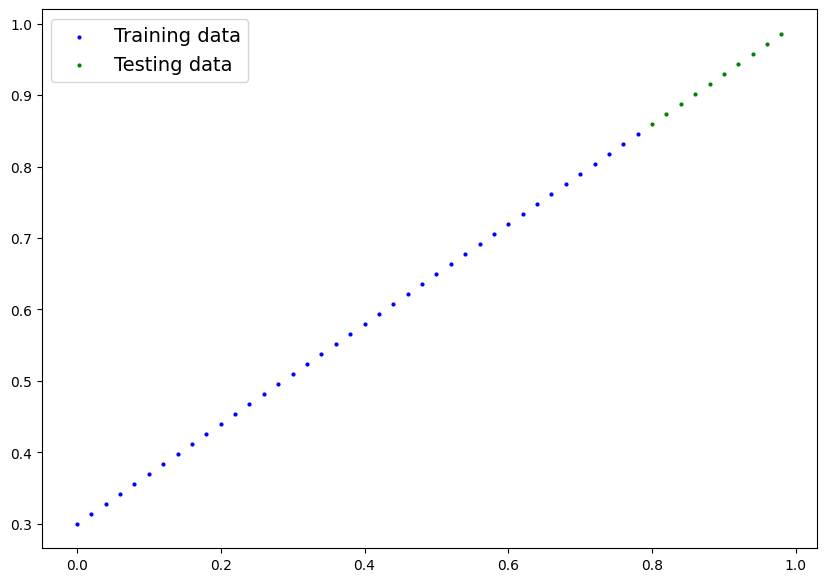

In [7]:
plot_predictions()

#### 2. Build model

First pytorch model

What are model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias used to create the data).

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [8]:
# Create linear regression model class
# nn.module: base class for all neural network modules

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float))
        
    # Forward method to define the compuation in the model
    # '->': is a function annotation
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

##### PyTorch model building essentials

* **torch.nn** - contains all the building for computational graphs(a neural network can be considered a computational graphs)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
* **torch.nn.Module** - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* **torch.optim** - this where the optimizers in pytorch live. will help the gradient descent.
* **def forward()** - all nn.module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

##### Checking the contents of our Pytorch model

Now we've created a model, lets see whats inside

We can check our models parametrs using `.parameters()`

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Checkout the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

##### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` and based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# Make predictions with model
with torch.inference_mode(): # <= disables gradient descent and backend data
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

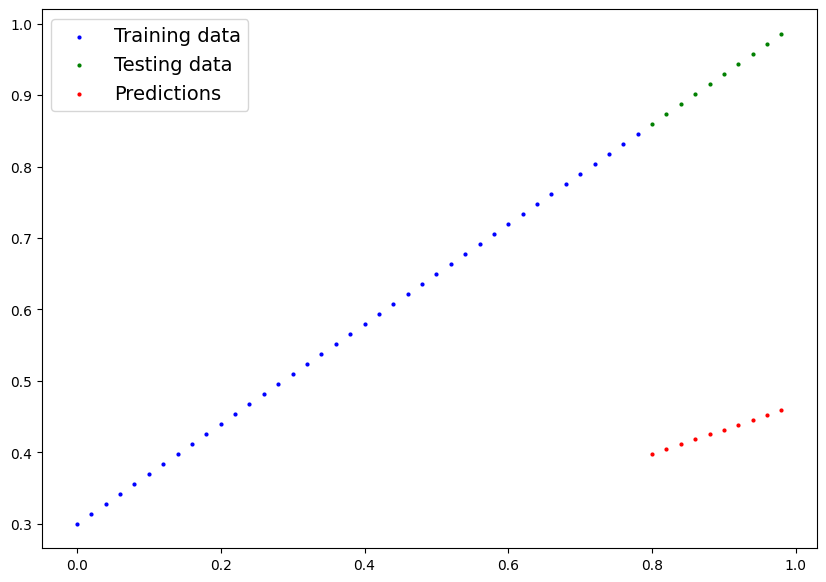

In [12]:
plot_predictions(prediction=y_preds)

#### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of data.

One way to measure how poor or how wrong your models predictions are is to use a **loss function**.

* Note: Loss function may also be called cost function or criterion in different areas. For now, we are going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (i.e. weight & bias) to improve the loss function.
    * Inside the optimizers you'll often have to set two parameters:
        * params - the model parameters
        * lr - learning rate of the optimizer

And specifically for pytorch, we need:
* A training loop
* A testing loop

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()


# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001) # lr = learning rate = one of the important hyperparameters (hyperparameters are parameters set by the researchers)

##### Building a training loop and testing loop in pytorch

A couple of things we need in a training loop:
1. Loop through the data
2. Forward pass (this involves data moving through our model's `forward()` functions) to make prediction on data - also called forward propagation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backwards - move backword through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [34]:
# An epoch is one loop through the data... (epoch is a hyperparameters)
epochs = 1000

# Track different vlaues
epoch_count = []
train_loss_values = []
test_loss_values = []

# step 1. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # training mode in pytorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimzier changes will acculmulate through the loop so.. we have to zero them above in step 3 for the next iteration of the loop

    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Prints what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
        print(model_0.state_dict())


Epoch: 0 | Loss: 0.174622043967247 | Test loss: 0.33273541927337646
OrderedDict([('weights', tensor([0.3835])), ('bias', tensor([0.2489]))])
Epoch: 10 | Loss: 0.1734698861837387 | Test loss: 0.3313881754875183
OrderedDict([('weights', tensor([0.3839])), ('bias', tensor([0.2499]))])
Epoch: 20 | Loss: 0.17231786251068115 | Test loss: 0.3300411105155945
OrderedDict([('weights', tensor([0.3843])), ('bias', tensor([0.2509]))])
Epoch: 30 | Loss: 0.1711658537387848 | Test loss: 0.32869404554367065
OrderedDict([('weights', tensor([0.3847])), ('bias', tensor([0.2519]))])
Epoch: 40 | Loss: 0.17001384496688843 | Test loss: 0.3273469805717468
OrderedDict([('weights', tensor([0.3851])), ('bias', tensor([0.2529]))])
Epoch: 50 | Loss: 0.16886183619499207 | Test loss: 0.3259999454021454
OrderedDict([('weights', tensor([0.3855])), ('bias', tensor([0.2539]))])
Epoch: 60 | Loss: 0.1677098125219345 | Test loss: 0.32465288043022156
OrderedDict([('weights', tensor([0.3859])), ('bias', tensor([0.2549]))])
Ep

In [35]:
import numpy as np
np.array(torch.tensor(train_loss_values).detach().numpy())

array([0.17462204, 0.17346989, 0.17231786, 0.17116585, 0.17001384,
       0.16886184, 0.16770981, 0.16655782, 0.1654058 , 0.16425379,
       0.16310178, 0.16194975, 0.16079774, 0.15964575, 0.15849373,
       0.15734172, 0.1561897 , 0.15503769, 0.15388568, 0.15273367,
       0.15158167, 0.15042965, 0.14927763, 0.14812563, 0.14697361,
       0.1458216 , 0.14466959, 0.14351758, 0.14236557, 0.14121355,
       0.14006154, 0.13890953, 0.13775751, 0.13660552, 0.13545349,
       0.13430148, 0.13314947, 0.13199745, 0.13084546, 0.12969343,
       0.12854144, 0.12738942, 0.1262374 , 0.1250854 , 0.12393336,
       0.12278136, 0.12162934, 0.12047734, 0.11932532, 0.11817332,
       0.11702131, 0.1158693 , 0.11479533, 0.1137406 , 0.11268587,
       0.11163113, 0.11057639, 0.10952165, 0.10852364, 0.10756232,
       0.106601  , 0.1056397 , 0.10467837, 0.10371705, 0.10276878,
       0.10189648, 0.1010242 , 0.10015191, 0.09927963, 0.09840733,
       0.09753505, 0.09670595, 0.09591863, 0.09513132, 0.09434

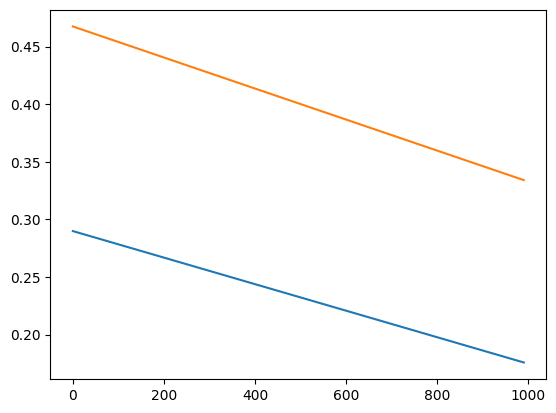

In [33]:
# Plot loss curve
'''
if converging: model is on right track
if diverging or not converging: model has problem
'''
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).detach().numpy()), label='Train loss')
plt.plot(epoch_count, np.array(test_loss_values), label='Test Loss')

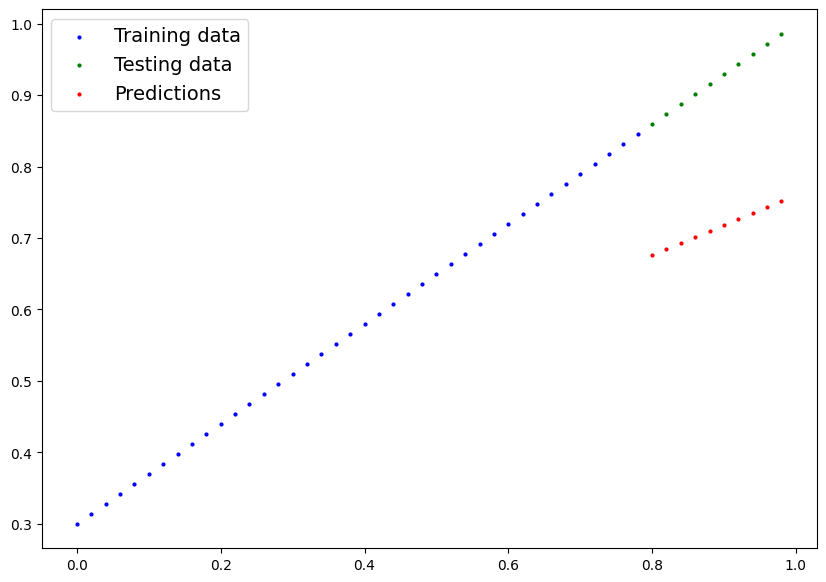

In [36]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(prediction=y_preds_new)

In [ ]:
weight, bias

(0.7, 0.3)

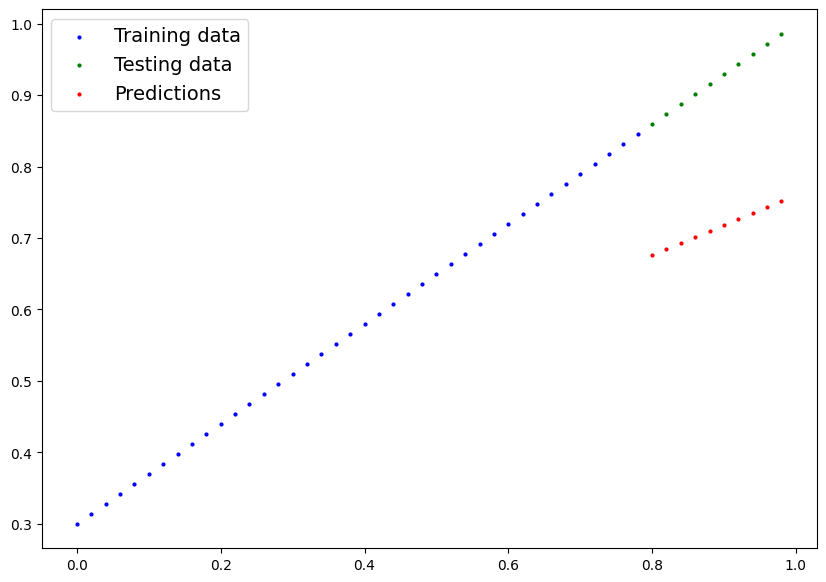

In [ ]:
plot_predictions(prediction=y_preds_new)

### Saving a model in pytorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict` - this allows to laod a model's saved state dictionary

In [40]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_python_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)